Analysis with the NA12878 dataset. Takes the windows from the DEL labeled windows from all chromosomes. The windows were labeled according to the nanosv calls (Nanopore data), taking into account the confidence interval (CIPOS and CIEND).

## Load dependencies and setting output configuration

In [1]:
import numpy as np
from keras.utils.np_utils import to_categorical
import keras
import gzip
from collections import Counter

%pylab inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


## Load data from npy files

In [ ]:
sample_name = 'NA12878'

#date = '230718'
#date = '060818'
date = '111018'
win = '50bp'

basedir = '/hpc/cog_bioinf/ridder/users/lsantuari/Processed/Test/'
datapath=basedir+date+'/'+win+'/TestData_'+date+'/'+sample_name+'/ChannelData/'
datapath_labels = basedir+date+'/'+win+'/TestData_'+date+'/'+sample_name+'/LabelData/'

#basedir = '/hpc/cog_bioinf/ridder/users/lsantuari/Git/DeepSV_runs/310518/CNN/scripts/'
#datapath=basedir+'/TestData_'+date+'/'+sample_name+'/ChannelData/'
#datapath_labels = basedir+'/TestData_'+date+'/'+sample_name+'/LabelData/'

filename = '_channel_maker_real_germline.npy.gz'

In [ ]:
# Load channel data and labels by chromosome

#Leaving out chromosome Y and MT for the moment
chr_list = list(map(str, np.arange(1,2)))
# chr_list.append('X')
print(chr_list)

data = []
labels = []

for i in chr_list:
#for i in [16, 17, 18]:
    
    print('Loading data and labels for Chr%s' % i)
    data_file = datapath + str(i) + filename
    with gzip.GzipFile(data_file, "rb") as f:
        data_mat = np.load(f)
        data.extend(data_mat)
    f.close()

    label_file = datapath_labels + str(i) + '_label_ci_full_overlap.npy.gz'
    
    with gzip.GzipFile(label_file, "rb") as f:
        data_lab = np.load(f)
        #The list still includes a value (0) at position 0 that
        #makes the window boundaries fall off the chromosome boundaries
        #if i == '17':
        #    data_lab = data_lab[1:]
        labels.extend(data_lab)
    f.close()
    # print('Length of data:%d, label length:%d' % (len(data_mat), len(data_lab)))
    assert len(data_mat) == len(data_lab)

print(Counter(labels))
assert len(data) == len(labels)

#X_test=data[np.where(labels != 'no_del')]
#y_test = labels[np.where(labels != 'no_del')]
#X_test = X_test[:, [0,1,2,11,12,13], :]
#data = []
#labels = []

In [28]:
%%time
# Save data and labels

use_gz = False
labels_only = False

if use_gz:

    if not labels_only:
        data_output_file = datapath + '../X.npy.gz'
        with gzip.GzipFile(data_output_file, "wb") as f:
            np.save(f, data)
        f.close()

    label_output_file = datapath + '../y.npy.gz'
    with gzip.GzipFile(label_output_file, "wb") as f:
        np.save(f, labels)
    f.close()

else:
    #No gz
    if not labels_only:
        data_output_file_npy = datapath + '../X'
        np.save(data_output_file_npy, data)

    label_output_file_npy = datapath + '../y'
    np.save(label_output_file_npy, labels)

CPU times: user 6.79 s, sys: 32.5 s, total: 39.3 s
Wall time: 1min 24s


In [4]:
%%time
# Load data and labels

use_gz = True

if use_gz:
    
    data_output_file = datapath + '../X.npy.gz'
    with gzip.GzipFile(data_output_file, "rb") as f:
        data = np.load(f)
    f.close()

    label_output_file = datapath + '../y.npy.gz'
    with gzip.GzipFile(label_output_file, "rb") as f:
        labels = np.load(f)
    f.close()

else:
        
    data_output_file_npy = datapath + '../X.npy'
    data = np.load(data_output_file_npy)

    label_output_file_npy = datapath + '../y.npy'
    labels = np.load(label_output_file_npy)

CPU times: user 2min 27s, sys: 18.7 s, total: 2min 45s
Wall time: 2min 45s


In [5]:
keep = np.where(np.array(labels)!='UK')

# If loaded:
#keep = np.where(labels!='UK')

#print(keep)

#print(data.shape())
#print(len(labels))

data = np.array(data)
labels = np.array(labels)

print(data.shape)
print(len(labels))

data = data[keep]
labels = labels[keep]

(1185753, 27, 200)
1185753


In [10]:
#print(labels)

In [6]:
#Relabel deletions
del_idx = np.where(np.logical_or(np.array(labels)=='DEL_start',np.array(labels)=='DEL_end'))
print(del_idx)
print(len(del_idx))
print(len(labels))
labels[del_idx] = 'DEL'

(array([    600,    1091,    1092, ..., 1175801, 1175802, 1176033]),)
1
1176122


In [7]:
cnt_lab = Counter(labels)
#print([v for k, v in cnt_lab.items()])
min_v = min([v for k, v in cnt_lab.items()])

print(cnt_lab)
print('Minimum number of labels = ' + str(min_v))
#np.concatenate(data[np.where(labels == 'noSV')][]

Counter({'noSV': 1168817, 'DEL': 7305})
Minimum number of labels = 7305


In [7]:
data_balanced = []
labels_balanced = []

for l in cnt_lab.keys():
    #print(l)
    iw = np.where(labels==l)
    #print(iw[0])
    ii = np.random.choice(a=iw[0], size=min_v, replace=False)
    data_balanced.extend(data[ii])
    labels_balanced.extend(labels[ii])

print(Counter(labels_balanced))

Counter({'noSV': 7305, 'DEL': 7305})


In [8]:
X = np.array(data_balanced)
y = np.array(labels_balanced)

In [63]:
# Selecting only a few channels
#indices = np.array([0,1,2,9,12,15,18,19,20,23,26])
#X = X[:,indices,:]

#include_ii = np.where(y!='noSV')
#X = X[include_ii]
#y = y[include_ii]

In [9]:
X.shape

(14610, 27, 200)

In [10]:
y.shape

(14610,)

### Number of channels

In [11]:
number_channels = X.shape[1]
number_channels

27

In [12]:
#Split into training, validation and test set 60/20/20
cnt_lab = Counter(labels_balanced)
n_lab = [v for v in cnt_lab.values()][0]
i_train = int(n_lab*0.6)
i_val = i_train + int(n_lab*0.2)
print(i_train)
print(i_val)

X_train = []
y_train = []
X_val = []
y_val = []
X_test = []
y_test = []

for l in cnt_lab.keys():
    iw = np.where(y==l)
    #print(iw[0])
    #print(iw[0][:i_train])
    X_train.extend(X[iw[0][:i_train]])
    X_val.extend(X[iw[0][i_train:i_val]])
    X_test.extend(X[iw[0][i_val:]])
    
    y_train.extend(y[iw[0][:i_train]])
    y_val.extend(y[iw[0][i_train:i_val]])
    y_test.extend(y[iw[0][i_val:]])

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)


4383
5844
(8766, 27, 200)
(2922, 27, 200)
(2922, 27, 200)
(8766,)
(2922,)
(2922,)


## Normalize data

In [ ]:
#coverage = np.median(X_train[:, 0, :]) #the median of the coverage in the normal cells
#coverage

#NA12878 median insert size: 368
#expected coverage:
hg19_len = 3095693981
read_len = 150
coverage = int(976976324 * read_len / hg19_len)
print(coverage)

In [ ]:
#not used now

expected_distance = 368

def normalize(X):       
    for i in range (0, len(X)):            
        for k in [3,5]:
            X[i][k] = np.divide(X[i][k],  X[i][1]/2 + 1/(10*X[i][1]+1)) #divide by number of clips
        for k in [4,6]:            
            X[i][k] = np.divide(X[i][k],  X[i][2]/2 +  1/(10*X[i][2]+1))
        for k in [3+11,5+11]:
            X[i][k] = np.divide(X[i][k],  X[i][1+11]/2 +  1/(10*X[i][12]+1))
        for k in [4+11,6+11]:            
            X[i][k] = np.divide(X[i][k],  X[i][2+11]/2+  1/(10*X[i][13]+1))
        for k in [3,4,5,6,14,15,16,17]:#the distance channels
            X[i][k] = np.divide(X[i][k], expected_distance)
        for j in range(0,number_channels):                                                                             
            X[i][j] = np.divide(X[i][j], coverage)*100
            
#normalize(X_train)
#normalize(X_val)
#normalize(X_test)

In [ ]:
#not used now

expected_distance = 150
def normalize(X):       
    for i in range (0, len(X)):                    
        for k in [3,4,5,6,14,15,16,17]:#the distance channels
            X[i][k] = np.divide(X[i][k], expected_distance)
        for j in range(0,number_channels):                                                                             
            X[i][j] = np.divide(X[i][j], coverage)*100     
normalize(X_train)
#normalize(X_val)
#normalize(X_test)

## Plots several  windows 

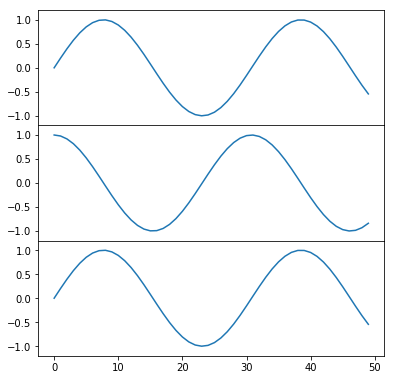

In [14]:
fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.5, 0.8, 0.4],
                   xticklabels=[],
                   ylim=(-1.2, 1.2))
ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.4],
                   ylim=(-1.2, 1.2))
ax3 = fig.add_axes([0.1, -0.3, 0.8, 0.4],
                   ylim=(-1.2, 1.2))

x = np.linspace(0, 10)
ax1.plot(np.sin(x))
ax2.plot(np.cos(x))
ax3.plot(np.sin(x));

noSV id: 1


AttributeError: 'Figure' object has no attribute 'set_cmap'

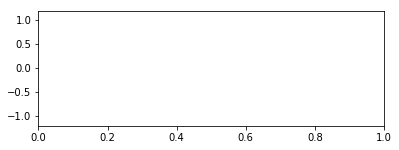

In [28]:
fig = plt.figure()
i = 1
shift = 0.4

print(y_train[i], 'id:', i)
#print('id:', i)
for j in range (0, number_channels): 

    ax = fig.add_axes([0.1, 0.1+j*shift, 0.8, 0.4],
                       ylim=(-1.2, 1.2))
    Z = [ (x - min(X_train[i][j]))/max(X_train[i][j]) for x in X_train[i][j]]

    ax.plot(Z)
        
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 5})    
#plt.show()

In [14]:
n_windows = X_train.shape[0]
label = ["None"] * number_channels

In [15]:
label[0] = "cov"
label[1] = "L_CR"
label[2] = "R_CR"

label[3] = "INV_B"
label[4] = "INV_A"
label[5] = "R_CR_DUP_B"
label[6] = "L_CR_DUP_A"

label[7] = "F_L_CR_sum"
label[8] = "F_L_CR_num"
label[9] = "F_L_CR_med"
label[10] = "F_R_CR_sum"
label[11] = "F_R_CR_num"
label[12] = "F_R_CR_med"

label[13] = "R_L_CR_dist_sum"
label[14] = "R_L_CR_dist_num"
label[15] = "R_L_CR_dist_med"
label[16] = "R_R_CR_dist_sum"
label[17] = "R_R_CR_dist_num"
label[18] = "R_R_CR_dist_med"

label[19] = "L_SR"
label[20] = "R_SR"

label[21] = "L_SR_dist_sum"
label[22] = "L_SR_dist_num"
label[23] = "L_SR_dist_med"

label[24] = "R_SR_dist_sum"
label[25] = "R_SR_dist_num"
label[26] = "R_SR_dist_med"

In [16]:
from numpy import *
import math
import matplotlib.pyplot as plt

colors =['b','g', 'm', 'gray', 'r','c', 'darkgreen' ,'y', 'k', 'orange', 'gray']

def plot_channels(start_window, n_windows):
    for i in range (start_window, start_window + n_windows, 5):
        print(y_train[i], 'id:', i)
        #print('id:', i)
        for j in range (0, number_channels):   
            if j in [3, 6, 14, 17]:
                continue
            shift = 0
            start =0
            if j in [0,11]:
                shift = -100
            if j > 10:
                start = -60
            Z = [start + shift + 300 + x - 5*j*4 for x in X_train[i][j]]  
            #plt.ylim([100,700])
            if np.max(Z) > 1000:
                plt.ylim([-200,1000])
                Z = [start + shift + 300 + x - 5*j*4 - 400 for x in X_train[i][j]]  
            if j>10:
                plt.plot(Z,  label = label[j], linestyle=':', linewidth=1.5, color = colors[j % 11])
            else:
                plt.plot(Z, label = label[j], color = colors[j])
        
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 5})    
        plt.show()

2594
noSV id: 0


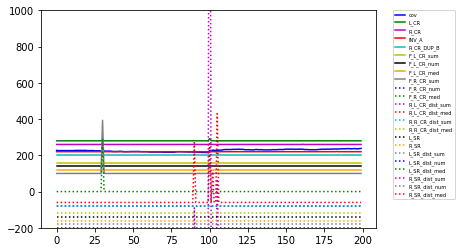

noSV id: 5


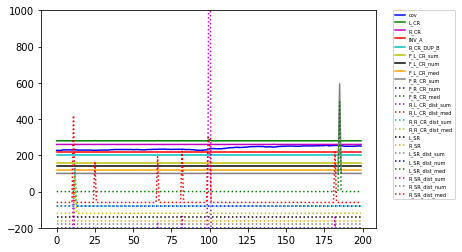

noSV id: 10


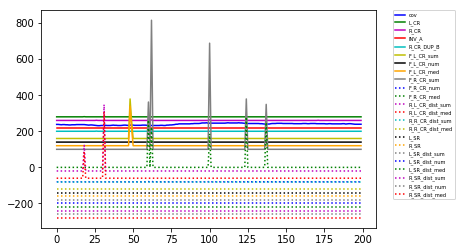

noSV id: 15


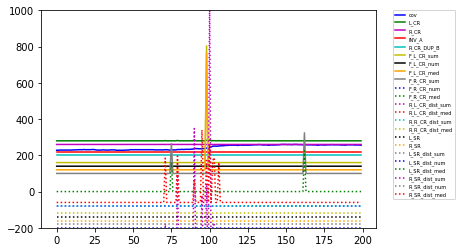

noSV id: 20


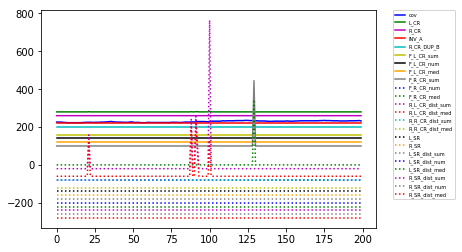

noSV id: 25


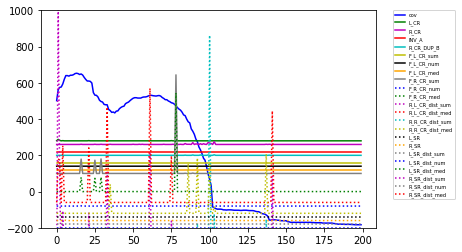

noSV id: 30


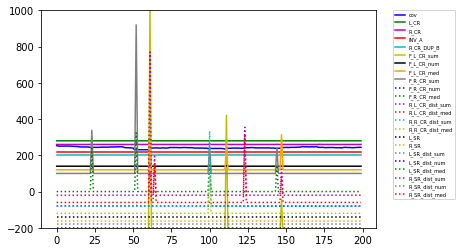

noSV id: 35


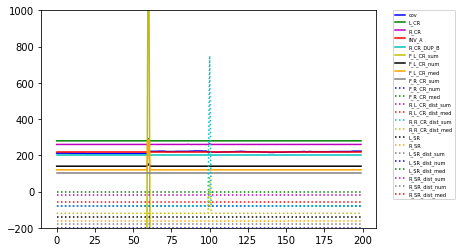

noSV id: 40


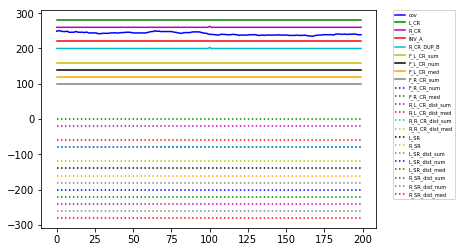

noSV id: 45


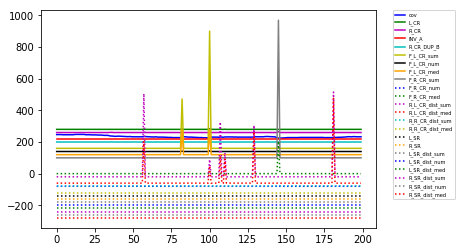

noSV id: 50


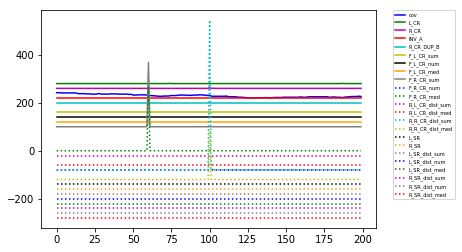

noSV id: 55


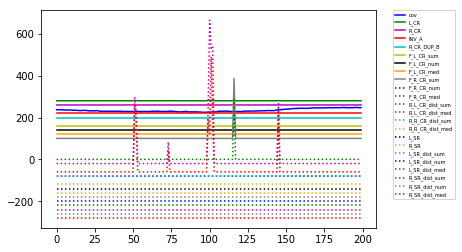

noSV id: 60


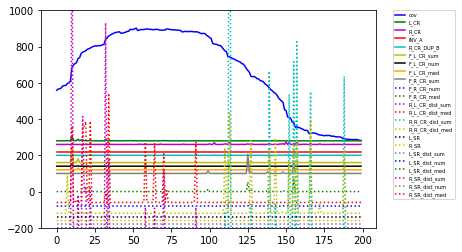

noSV id: 65


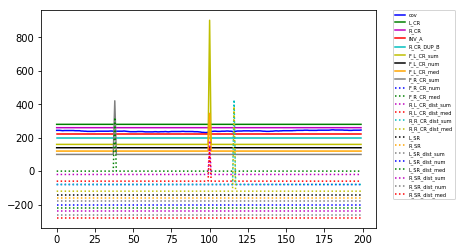

noSV id: 70


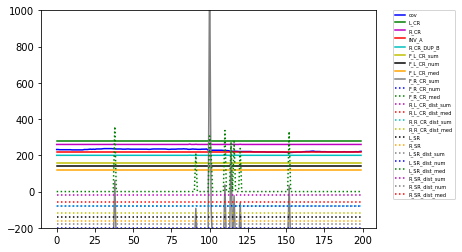

noSV id: 75


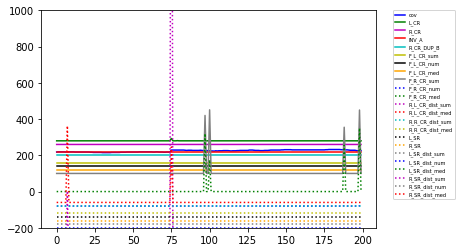

noSV id: 80


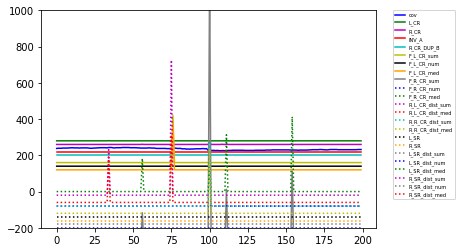

noSV id: 85


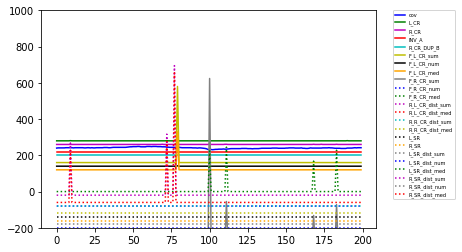

noSV id: 90


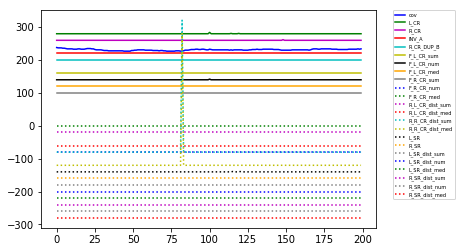

noSV id: 95


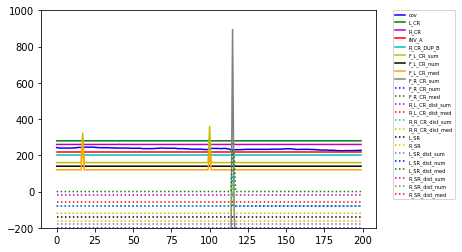

noSV id: 100


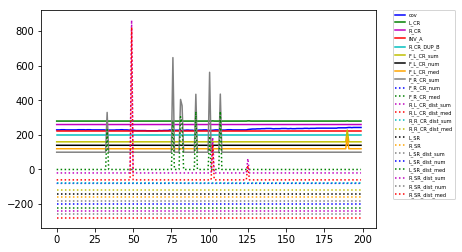

noSV id: 105


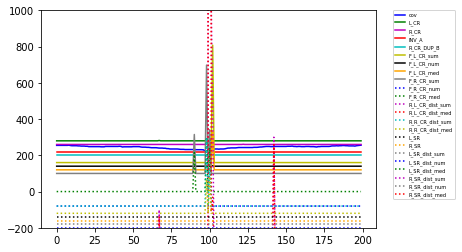

noSV id: 110


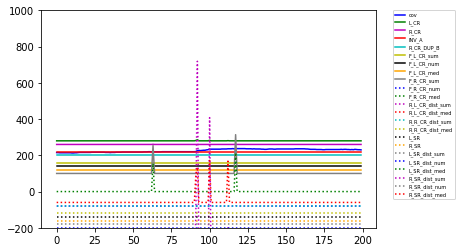

noSV id: 115


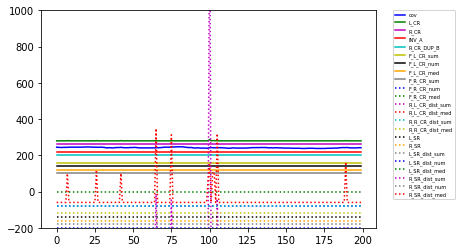

noSV id: 120


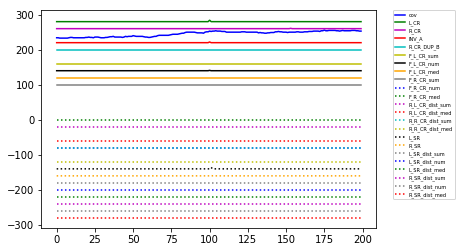

noSV id: 125


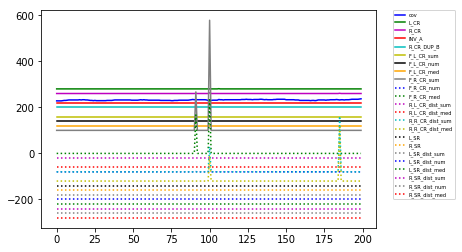

noSV id: 130


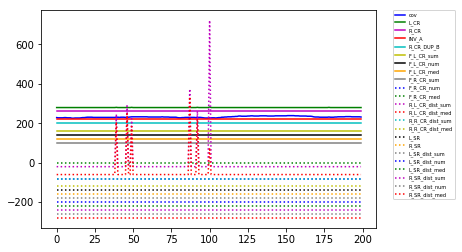

noSV id: 135


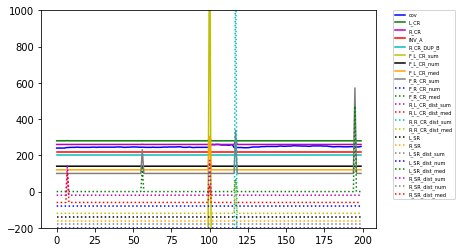

noSV id: 140


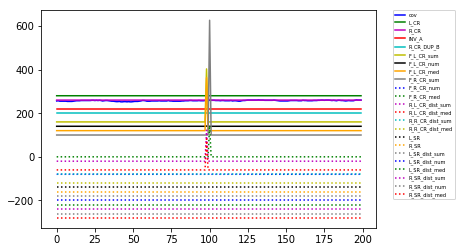

noSV id: 145


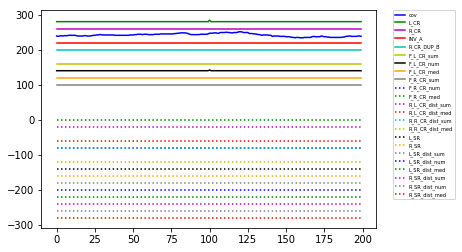

noSV id: 150


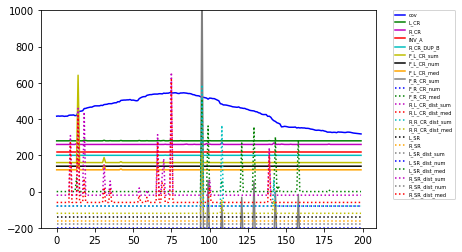

noSV id: 155


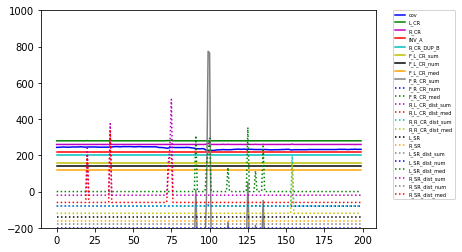

noSV id: 160


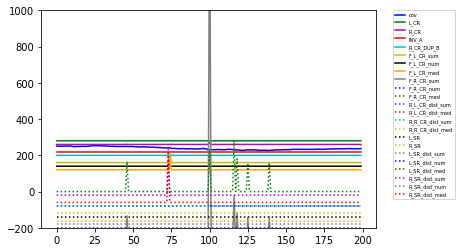

noSV id: 165


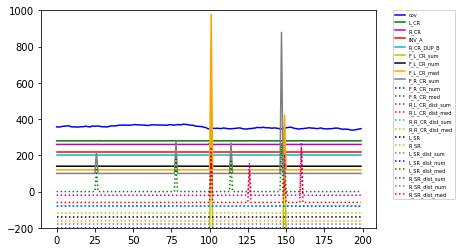

noSV id: 170


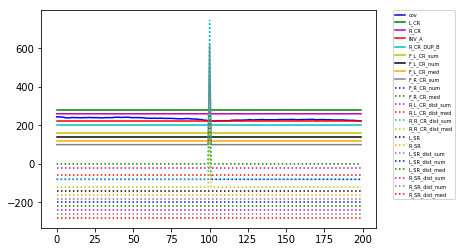

noSV id: 175


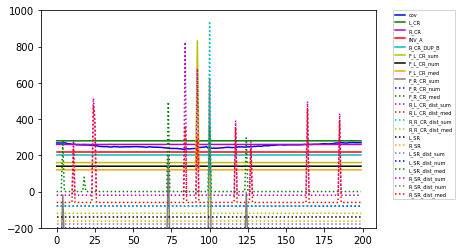

noSV id: 180


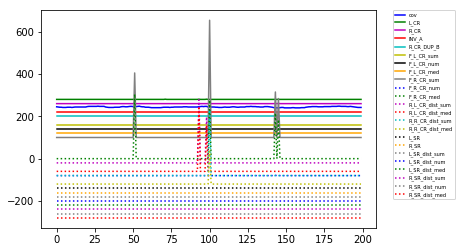

noSV id: 185


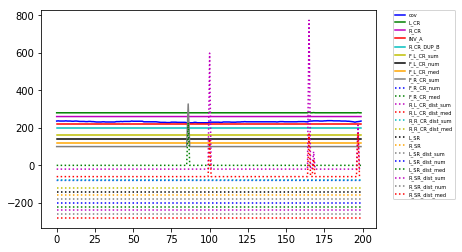

noSV id: 190


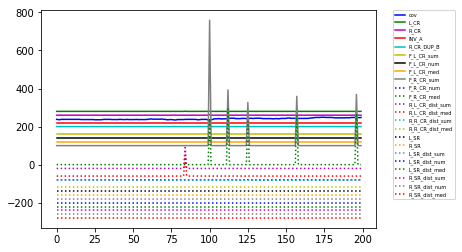

noSV id: 195


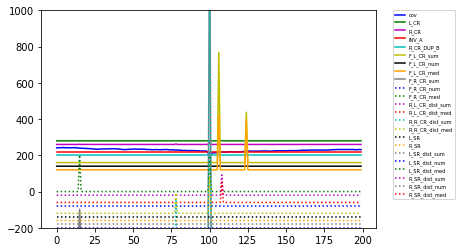

noSV id: 200


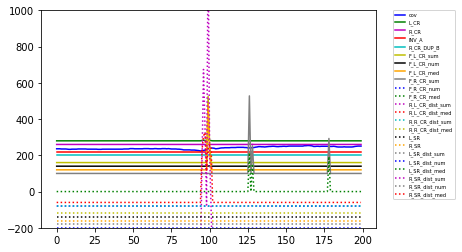

noSV id: 205


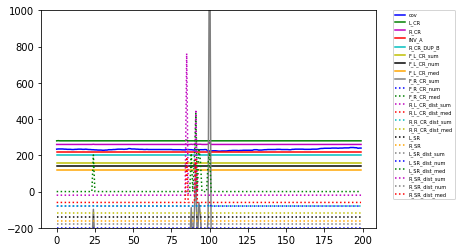

noSV id: 210


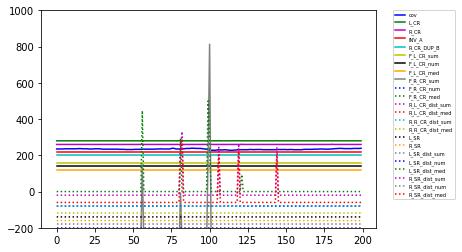

noSV id: 215


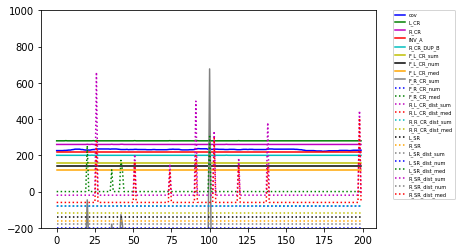

noSV id: 220


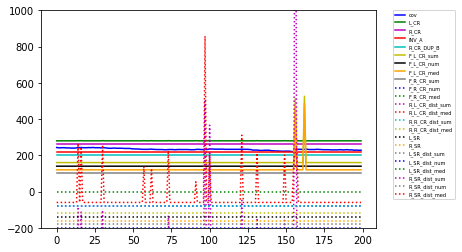

noSV id: 225


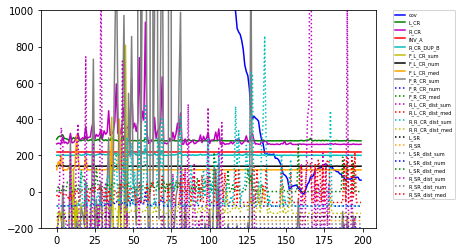

noSV id: 230


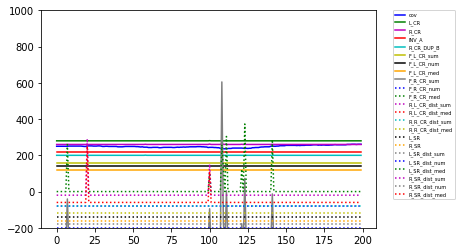

noSV id: 235


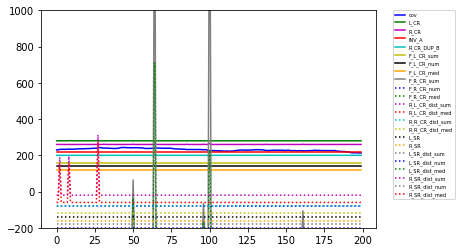

noSV id: 240


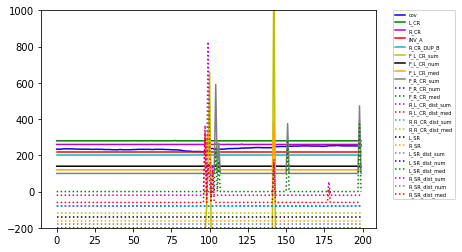

noSV id: 245


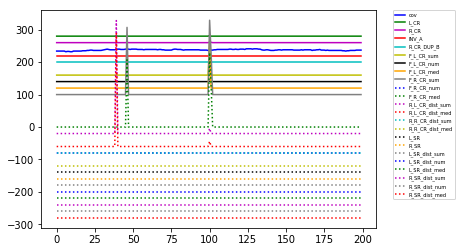

noSV id: 250


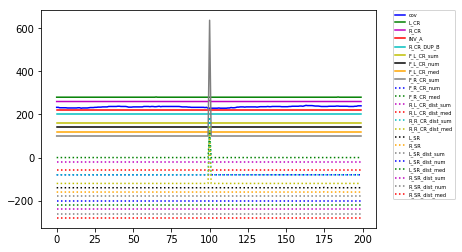

noSV id: 255


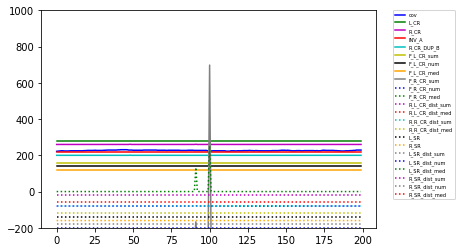

noSV id: 260


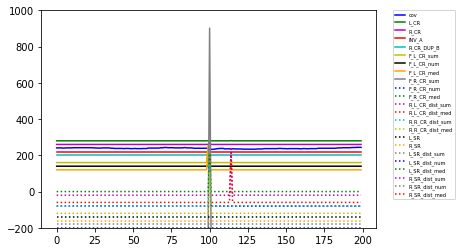

noSV id: 265


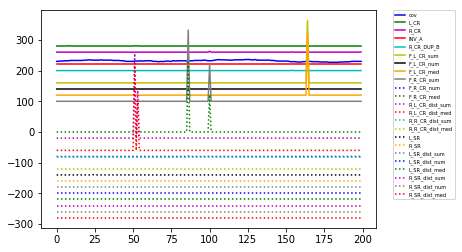

noSV id: 270


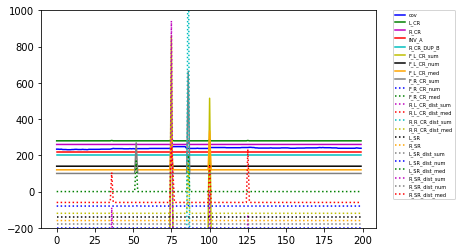

noSV id: 275


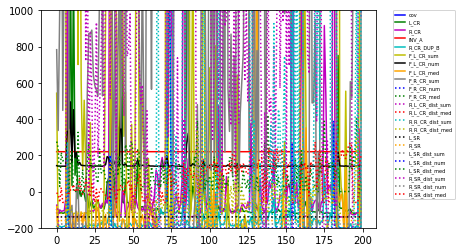

noSV id: 280


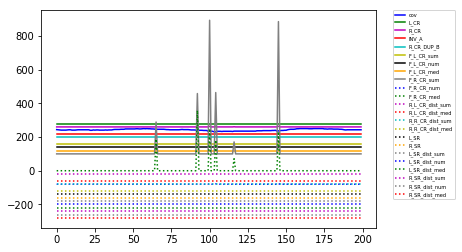

noSV id: 285


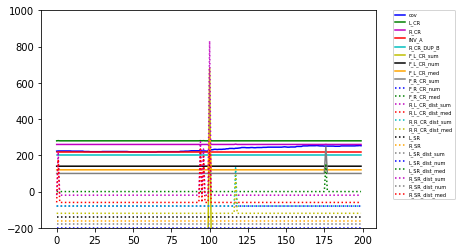

noSV id: 290


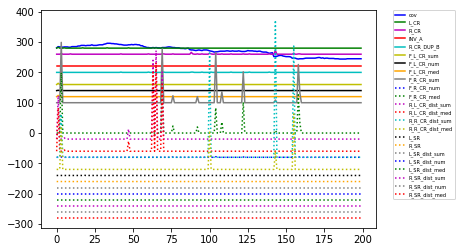

noSV id: 295


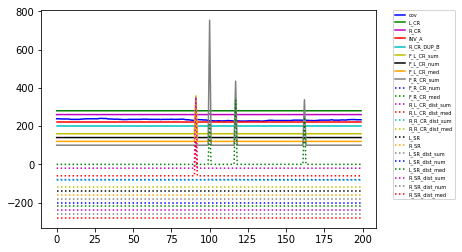

In [18]:
start_window = 0
print(n_windows)
#plot_channels(start_window, n_windows)

#print(Counter(y_train))

plot_channels(start_window, 300)

   
## Transposes every window in X, to comply to McFly format

In [13]:
def transposeDataset(X):
    image = []
    for i in range (0, len(X-1)):
        tr = X[i].transpose()
        image.append(tr)
    return np.array(image)

image1 = transposeDataset(X_train)
image2 = transposeDataset(X_val)
image3 = transposeDataset(X_test)
X_train = image1
X_val = image2
X_test = image3

n_channels = len(X_train[0][0])
print(len(X_test[0][0]))

27


## Prepare the labels in McFly format

In [14]:
classlabels = list(set(y_train))
mapclasses = {classlabels[i] : i for i in range(len(classlabels))}
print(mapclasses)

y_train = np.array([mapclasses[c] for c in y_train], dtype='int')
y_val = np.array([mapclasses[c] for c in y_val], dtype='int')
y_test = np.array([mapclasses[c] for c in y_test], dtype='int')

y_train_binary = to_categorical(y_train)
y_val_binary = to_categorical(y_val)
y_test_binary = to_categorical(y_test)

{'DEL': 0, 'noSV': 1}


In [70]:
y_test_binary

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

## Generate neural networks architectures

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, MaxPooling1D
from keras.optimizers import Adam
import sys
import os
import numpy as np
sys.path.insert(0, os.path.abspath('..'))
from mcfly import modelgen, find_architecture

In [16]:
#From https://stackoverflow.com/questions/43076609/how-to-calculate-precision-and-recall-in-keras
import tensorflow as tf

def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper

precision = as_keras_metric(tf.metrics.precision)
recall = as_keras_metric(tf.metrics.recall)

In [17]:
np.random.seed = 321
num_classes = y_train_binary.shape[1]

In [18]:
%%time

models = modelgen.generate_models(X_train.shape,
                                  num_classes,
                                  number_of_models = 1,
                                  model_type = 'CNN',
                                  cnn_min_layers=1,
                                  cnn_max_layers=1,
                                  cnn_min_fc_nodes=4, 
                                  cnn_max_fc_nodes=6,
                                  low_lr=4, high_lr=4,
                                  metrics=['accuracy', precision, recall])

# models = modelgen.generate_models(X_train.shape,
#                                   num_classes,
#                                   number_of_models = 1,
#                                   model_type = 'DeepConvLSTM',
#                                   cnn_min_layers=1,
#                                   cnn_max_layers=1,
#                                   cnn_min_fc_nodes=4, 
#                                   cnn_max_fc_nodes=6,
#                                   low_lr=4, high_lr=4)

CPU times: user 1.1 s, sys: 1.42 s, total: 2.52 s
Wall time: 2.51 s


In [19]:
%%time
for model, params, model_types in models:
    print(params)
    model.summary()

{'learning_rate': 0.0001, 'regularization_rate': 0.011409261721375392, 'filters': array([75]), 'fc_hidden_nodes': 6}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 200, 27)           108       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 200, 75)           6150      
_________________________________________________________________
batch_normalization_2 (Batch (None, 200, 75)           300       
_________________________________________________________________
activation_1 (Activation)    (None, 200, 75)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 15000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 90006     
_________________________

## Train the networks

In [20]:
train_set_size = X_train.shape[0]
train_set_size

8766

In [21]:
# Define directory where the results, e.g. json file, will be stored
resultpath = os.path.join(datapath, '../data/models_PrecRec_test')
if not os.path.exists(resultpath):
        os.makedirs(resultpath)

In [22]:
%%time
outputfile = os.path.join(resultpath, 'modelcomparison.json')
histories, val_accuracies, val_losses = find_architecture.train_models_on_samples(X_train, y_train_binary,
                                                                                  X_val, y_val_binary,
                                                                                  models,nr_epochs=1, 
                                                                                  subset_size=train_set_size,
                                                                                  verbose=True,
                                                                                  outputfile=outputfile,
                                                                                  metric='accuracy')
print('Details of the training process were stored in ',outputfile)

Training model 0 CNN
Train on 8766 samples, validate on 2922 samples
Epoch 1/1
8766/8766 [==============================] - 7s 769us/step - loss: 1.3830 - acc: 0.7082 - precision: 0.4989 - recall: 0.9977 - val_loss: 1.3334 - val_acc: 0.6434 - val_precision: 0.5000 - val_recall: 1.0000
Details of the training process were stored in  /hpc/cog_bioinf/ridder/users/lsantuari/Git/DeepSV_runs/310518/CNN/scripts//TestData_060818/NA12878/ChannelData/../data/models_PrecRec_test/modelcomparison.json
CPU times: user 11.1 s, sys: 1.78 s, total: 12.9 s
Wall time: 7.55 s


## Plot training process

Currently run with a very low number of epochs

In [43]:
#%%time
#for i in range(len(models)):
#    name = str(models[i][1])
#    find_architecture.plotTrainingProcess(histories[i], name)



In [23]:
#%%time
import pandas as pd
results = pd.DataFrame({'model':[str(params) for model, params, model_types in models],
                       'train_acc': [history.history['acc'][-1] for history in histories],
                       'train_loss': [history.history['loss'][-1] for history in histories],
                       'val_acc': [history.history['val_acc'][-1] for history in histories],
                       'val_loss': [history.history['val_loss'][-1] for history in histories]
                       })
results

,model,train_acc,train_loss,val_acc,val_loss
0,"{'learning_rate': 0.0001, 'regularization_rate...",0.708191,1.383035,0.643395,1.333354


## Take the best current model 

In [24]:
best_model_index = np.argmax(val_accuracies)

In [25]:
best_model, best_params, best_model_types = models[best_model_index]
print(best_model_index, best_model_types, best_params)

0 CNN {'learning_rate': 0.0001, 'regularization_rate': 0.011409261721375392, 'filters': array([75]), 'fc_hidden_nodes': 6}


## Save the best current model

In [26]:
from keras.models import load_model

model_path = os.path.join(resultpath, sample_name+'_best_model')

best_model.save(model_path)

## Reload the best current model

In [27]:

model_reloaded = load_model(model_path, custom_objects={'precision': precision, 'recall':recall})

## Test best current model on testset

### Overall accuracy on the test set:

In [28]:
score_test = model_reloaded.evaluate(X_test, y_test_binary, verbose=True)
print('Test loss and accuracy of best model: ' + str(score_test))

2922/2922 [==============================] - 1s 187us/step
Test loss and accuracy of best model: [1.3445855535765694, 0.6379192334068793, 0.4945242984257358, 0.9890485968514716]


### Re-check the train and validation scores: 

In [29]:
best_model.get_config()[0]

{'class_name': 'BatchNormalization',
 'config': {'name': 'batch_normalization_1',
  'trainable': True,
  'batch_input_shape': (None, 200, 27),
  'dtype': 'float32',
  'axis': -1,
  'momentum': 0.99,
  'epsilon': 0.001,
  'center': True,
  'scale': True,
  'beta_initializer': {'class_name': 'Zeros', 'config': {}},
  'gamma_initializer': {'class_name': 'Ones', 'config': {}},
  'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}},
  'moving_variance_initializer': {'class_name': 'Ones', 'config': {}},
  'beta_regularizer': None,
  'gamma_regularizer': None,
  'beta_constraint': None,
  'gamma_constraint': None}}

In [30]:
score_train = model_reloaded.evaluate(X_train, y_train_binary, verbose=False)
print('Train Score of best model: ' + str(score_train))

Train Score of best model: [1.342291470398621, 0.6429386265591185, 0.5, 1.0]


In [31]:
score_val = model_reloaded.evaluate(X_val, y_val_binary, verbose=False)
print('Val Score of best model: ' + str(score_val))

Val Score of best model: [1.3333539785708899, 0.6433949349862431, 0.5, 1.0]


In [32]:
## Inspect model predictions on validation data
datasize = X_val.shape[0]
probs = model.predict_proba(X_val[:datasize,:,:],batch_size=1)

In [33]:
#columns are predicted, rows are truth
predicted = probs.argmax(axis=1)
#print(predicted)
y_index = y_val_binary.argmax(axis=1)

#print(y_index)
confusion_matrix = pd.crosstab(pd.Series(y_index), pd.Series(predicted))
confusion_matrix.index = [classlabels[i] for i in confusion_matrix.index]
confusion_matrix.columns = [classlabels[i] for i in confusion_matrix.columns]
confusion_matrix.reindex(columns=[l for l in classlabels], fill_value=0)
confusion_matrix

,DEL,noSV
DEL,433,1028
noSV,14,1447


In [36]:
predicted = probs.argmax(axis=1)
print(probs.shape)
print(probs)
predicted = probs.argmax(axis=0)
print(predicted.shape)

(2922, 2)
[[0.31013775 0.6898622 ]
 [0.31105626 0.68894374]
 [0.3072771  0.69272286]
 ...
 [0.36608365 0.6339163 ]
 [0.31210315 0.68789685]
 [0.31155804 0.68844193]]
(2,)


In [49]:
for i in np.arange(0.5,0.99,0.01):
    print(i)
    #print(len(np.argwhere(probs>i)))
    
    predicted = np.argwhere(probs>i)[:,1]
    y_index = np.argwhere(y_val_binary>i)[:,1]

    confusion_matrix = pd.crosstab(pd.Series(y_index), pd.Series(predicted))
    confusion_matrix.index = [classlabels[i] for i in confusion_matrix.index]
    confusion_matrix.columns = [classlabels[i] for i in confusion_matrix.columns]
    confusion_matrix.reindex(columns=[l for l in classlabels], fill_value=0)
    print(confusion_matrix)

0.5
      DEL  noSV
DEL   433  1028
noSV   14  1447
0.51
      DEL  noSV
DEL   409  1007
noSV   14  1447
0.52
      DEL  noSV
DEL   394   979
noSV   13  1448
0.53
      DEL  noSV
DEL   369   954
noSV   12  1449
0.54
      DEL  noSV
DEL   345   923
noSV   11  1450
0.55
      DEL  noSV
DEL   340   882
noSV   11  1450
0.56
      DEL  noSV
DEL   316   854
noSV   12  1449
0.5700000000000001
      DEL  noSV
DEL   298   817
noSV   11  1450
0.5800000000000001
      DEL  noSV
DEL   282   789
noSV   14  1447
0.5900000000000001
      DEL  noSV
DEL   254   755
noSV   15  1446
0.6000000000000001
      DEL  noSV
DEL   241   729
noSV   16  1445
0.6100000000000001
      DEL  noSV
DEL   230   698
noSV   19  1442
0.6200000000000001
      DEL  noSV
DEL   208   669
noSV   21  1440
0.6300000000000001
      DEL  noSV
DEL   193   635
noSV   28  1433
0.6400000000000001
      DEL  noSV
DEL   186   594
noSV   31  1430
0.6500000000000001
      DEL  noSV
DEL   166   538
noSV   35  1426
0.6600000000000001
      DE

In [48]:
i = 0.5
predicted_argw = np.argwhere(probs>i)[:,1]
predicted_argm = probs.argmax(axis=1)

print(np.array_equal(predicted_argw, predicted_argm))

[1 1 1 ... 1 1 1]
True
